<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load stock price 
*  Recurrent Neural Networks and LSTM Networks 
https://builtin.com/data-science/recurrent-neural-networks-and-lstm
* Provider: https://www.alphavantage.co/documentation/#dailyadj 
* API key:3F4URDEKOPLFH25T

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests
import json
from datetime import datetime, timedelta


In [ ]:
# https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=LVS&apikey=3F4URDEKOPLFH25T&outputsize=full
ticker = "MRNA"
look_back = 8
predict_days = 45
df = pd.read_json('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T')
#df.columns, "----------------------------------------------------", df

X[0]: [1] y[0]: [14.47] X[-1]: [700] y[-1]: [341.09]


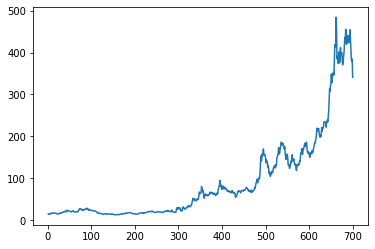

In [ ]:
dates = []
X = []
y = []
CLOSE_PRICE_COLUMN = "4. close"
ADJUSTED_PRICE_COLUMN = "5. adjusted close"
day = 0

for key, value in df['Time Series (Daily)'].items():
  try:
    dates.append([pd.to_datetime(key)])
    #print("key:", pd.to_datetime(key), "value:", float(value.get(CLOSE_PRICE_COLUMN)))
    
    day = day + 1
    price = float(value.get(ADJUSTED_PRICE_COLUMN))

    X.append([day])
    y.append([price])
  except:
    #print("Ignored key:", key, " value:", value)
    False

dates = dates[:600]
X = X[:700] # last 1000 days ~ 3 years
y = y[:700] # last 1000 days ~ 3 years

y = np.flip(y) # first day [0] = first price, last day [2000]= last price

print("X[0]:",X[0], "y[0]:", y[0], "X[-1]:",X[-1], "y[-1]:", y[-1])
plt.plot(X, y)

train_size: 630 test_size: 70 max: tf.Tensor(484.47, shape=(), dtype=float64) min: tf.Tensor(12.26, shape=(), dtype=float64)
last train price: [212.04] at: 2021-07-24 first test price: [220.14] last test price: [341.09] at: 2021-10-02


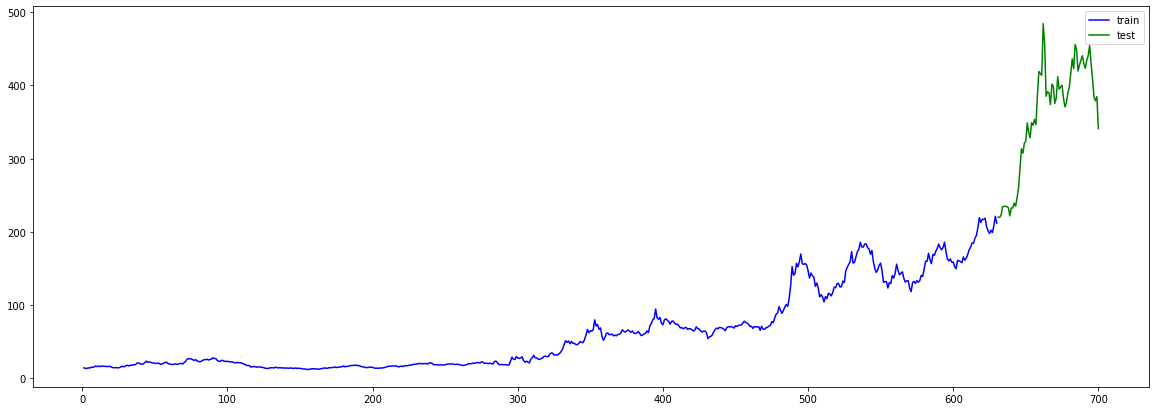

In [ ]:
train_size = int((np.size(y) / 100) * 90)
test_size = np.size(y) - train_size
print("train_size:",train_size, "test_size:",test_size, "max:", tf.reduce_max(y), "min:", tf.reduce_min(y))

X_train_chart = X[:train_size]
y_train_chart = y[:train_size]

y_test_chart = y[train_size:]
X_test_chart = X[train_size:]

last_train_day = datetime.today() - timedelta(days=test_size)

print("last train price:",y_train_chart[-1], "at:",f"{last_train_day.date():%Y-%m-%d}", 
      "first test price:", y_test_chart[0], 
      "last test price:", y_test_chart[-1], "at:", f"{datetime.today():%Y-%m-%d}")

plt.figure(figsize=(20,7))
plt.plot(X_train_chart, y_train_chart, color="blue", label= "train")
plt.plot(X_test_chart, y_test_chart, color="green", label="test")
plt.legend();
plt.show()


In [ ]:
# Normalizing data, scale between 0 and 1:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = sc.fit_transform(y_train_chart)
y_test_scaled = sc.fit_transform(y_test_chart)
y_train_scaled.shape, y_test_scaled.shape

((630, 1), (70, 1))

In [ ]:
def create_LSTM_input(X,look_back=1):
    X_train, y_train = [], []
    for i in range(look_back, len(X)):
      X_train.append(X[i-look_back:i, 0])
      y_train.append(X[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train

In [ ]:
# reshape to [samples, look_back, n_features]
X_train, y_train = create_LSTM_input(np.array(y_train_scaled), look_back)
print(X_train.shape, y_train.shape)

(622, 8, 1) (622,)


In [ ]:
# Building Model:
# The LSTM layer expects the number of time steps and the number of features to work properly.
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True,
                               input_shape=(look_back, 1)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1))

#model.summary()

In [ ]:
#from tensorflow.keras.utils import plot_model

#plot_model(model=model,show_shapes=True,show_layer_names=True)

In [ ]:
model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["mae"]
)

In [ ]:
modelo = model.fit(X_train, y_train, epochs=100, verbose=0)

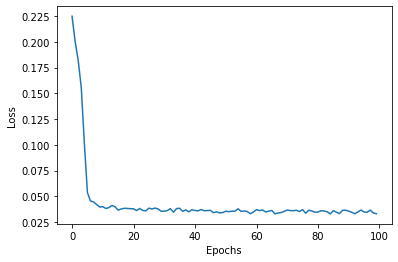

In [ ]:
plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
X_test, y_test = create_LSTM_input(np.array(y_test_scaled), look_back)
print(X_test.shape)

predicted_stock_price = model.predict(X_test)
predicted_stock_price.shape

(62, 8, 1)


(62, 1)

In [ ]:
#test_list = y_test_chart[-look_back:].reshape((-1))
#for i in range(10):
#  x = test_list[-look_back:]
#  x = x + 1
#  test_list = np.append(test_list,x)
#print(test_list)

In [ ]:
#print(predicted_stock_price[1],predicted_stock_price[-1:])
#close_data = y_test_scaled.reshape((-1))
prediction_list = y_test_scaled[-look_back:].reshape((-1))

#print(prediction_list)
for i in range(predict_days):
    x = prediction_list[-look_back:]
    x = x.reshape((1,look_back,1))
    out = model.predict(x)[0][0]
#    print(i,x,out)
    prediction_list = np.append(prediction_list, out)
prediction_list = prediction_list[look_back-1:]

FF = []
for x in prediction_list:
  FF.append([x])

#print(FF)
#X_future, y_future = create_LSTM_input(FF, look_back)
#predicted_future_stock_price = model.predict(X_future)
#predicted_future_stock_price.shape

In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_future_stock_price = sc.inverse_transform(FF)

In [ ]:
print(predicted_stock_price[-1], predicted_future_stock_price[0])

future_start = X_test_chart[-1][0]
future_end = future_start + predicted_future_stock_price.size
print(future_start,future_end)
X_future = []

for i in range(future_start,future_end):
  X_future.append([i]);
#  print(i," ", predicted_stock_price[i] , " " , predicted_future_stock_price[i])

#print(X_future)
#print(X_test_chart)
print(predicted_future_stock_price.reshape((-1)))

[429.45123] [341.09]
700 746
[341.09       424.46169193 415.42948916 400.45241501 390.06399509
 384.66987259 386.05864903 389.42182789 391.59264251 406.03659553
 398.66480681 392.75359844 390.45704027 391.0219481  393.31268818
 395.50800506 396.96335069 397.8981259  394.87198707 393.59818517
 393.92961207 395.01721891 396.09825082 396.65502277 396.64758065
 396.23395925 395.54032785 395.6601114  396.19315369 396.71930571
 397.01167721 397.04258096 396.93512738 396.84090249 396.88118773
 397.14850512 397.43531079 397.62216808 397.69815029 397.71833233
 397.75294137 397.84451737 397.99531503 398.17228627 398.31258296
 398.40576721]


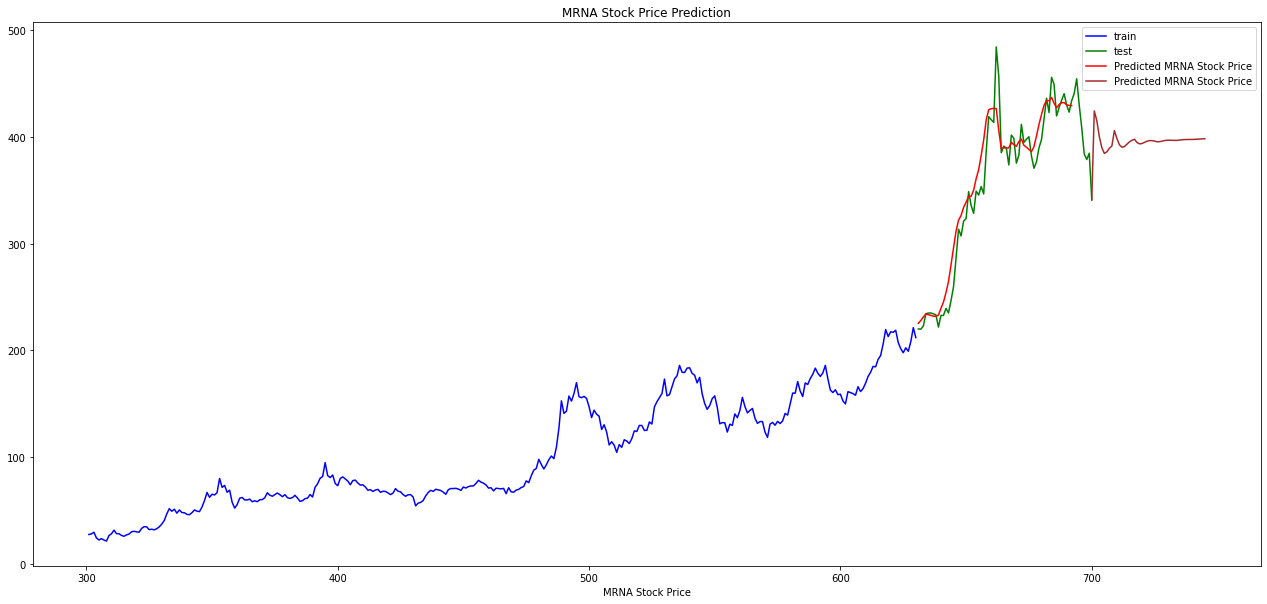

In [ ]:

plt.figure(figsize=(22, 10))

zoom = 300
plt.plot(X_train_chart[zoom:], y_train_chart[zoom:], color="blue", label="train")
plt.plot(X_test_chart, y_test_chart, color="green", label="test")
plt.plot(X_test_chart[:len(predicted_stock_price)], predicted_stock_price, color='red', label='Predicted '+ticker+' Stock Price')

plt.plot(X_future, predicted_future_stock_price, color='brown', label='Predicted '+ticker+' Stock Price')


plt.title(ticker + ' Stock Price Prediction')
plt.xlabel('Time')
plt.xlabel(ticker + ' Stock Price')
plt.legend()
plt.show()
